**Import Libraries**

In [1]:
import requests
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
import nltk
import re

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bedos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bedos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Fetching Movies Via TMDB API**

Scraping the data makes it easier for preprocessing as we only take what we need in data

In [3]:
def fetch_movies(api , max_movies=100):
    movies_data = []
    base_url = "https://api.themoviedb.org/3/discover/movie"
    params ={
        "api_key": api,
        "language": "en-US",
        "sort_by": "popularity.desc",
        "page": 1,
        "append_to_response": "release_dates"
    }

    movie_count = 0
    while movie_count < max_movies:
        response = requests.get(base_url, params=params)
        if response.status_code != 200:
            break
        
        data = response.json()
        for movie in data['results']:
            if movie_count >= max_movies:
                break

        # Fetch and append movie data

            movie_id = movie['id']
            movie_details_url = f"https://api.themoviedb.org/3/movie/{movie_id}"
            movie_credits_url = f"https://api.themoviedb.org/3/movie/{movie_id}/credits"
            details_params = {"api_key": api, "language": "en-US"}

            details_response = requests.get(movie_details_url, params=details_params)
            credits_response = requests.get(movie_credits_url, params=details_params)

            if details_response.status_code == 200 and credits_response.status_code == 200:
                details = details_response.json()
                credits = credits_response.json()

                age_rating = 'N/A'
                release_dates = details.get('release_dates', {}).get('results', [])
                for entry in release_dates:
                    if entry.get('iso_3166_1') == 'US':
                        for release in entry.get('release_dates', []):
                            if release.get('certification'):
                                age_rating = release['certification']
                                break
                        if age_rating != 'N/A':
                            break

                movies_data.append({
                    "title": movie["title"],
                    "rating": movie["vote_average"],
                    "genres": ', '.join([genre['name'] for genre in details.get("genres", [])]),
                    "description": movie["overview"],
                    "release_date": details.get("release_date", 'N/A')[:4],
                    "poster" : f"https://image.tmdb.org/t/p/w500{movie['poster_path']}" if movie.get("poster_path") else None,
                    "cast": ", ".join([cast_member['name'] for cast_member in credits.get("cast", [])[:5]]),
                    "age_rating": age_rating
                })
                
                movie_count += 1
        print(f"Fetched {movie_count} movies...")
        print(f"Completed page {params['page']}")
        print(f"Progress: {(min(movie_count, max_movies) / max_movies) * 100:.2f}%")
        params["page"] += 1    
        
    df = pd.DataFrame(movies_data)
    df = df.drop_duplicates(subset=['title']).reset_index(drop=True)
    df.to_csv("movies_data.csv", index=False)
    return df



In [6]:
api_key = "040f626c45591d5c219f86adfe749da8"

print("Fetching movie data...")
movies_df = fetch_movies(api_key, max_movies=6000)
print("Movie data fetched and saved to movies_data.csv")


Fetching movie data...
Fetched 20 movies...
Completed page 1
Progress: 0.33%
Fetched 40 movies...
Completed page 2
Progress: 0.67%
Fetched 60 movies...
Completed page 3
Progress: 1.00%
Fetched 80 movies...
Completed page 4
Progress: 1.33%
Fetched 100 movies...
Completed page 5
Progress: 1.67%
Fetched 120 movies...
Completed page 6
Progress: 2.00%
Fetched 140 movies...
Completed page 7
Progress: 2.33%
Fetched 160 movies...
Completed page 8
Progress: 2.67%
Fetched 180 movies...
Completed page 9
Progress: 3.00%
Fetched 200 movies...
Completed page 10
Progress: 3.33%
Fetched 220 movies...
Completed page 11
Progress: 3.67%
Fetched 240 movies...
Completed page 12
Progress: 4.00%
Fetched 260 movies...
Completed page 13
Progress: 4.33%
Fetched 280 movies...
Completed page 14
Progress: 4.67%
Fetched 300 movies...
Completed page 15
Progress: 5.00%
Fetched 320 movies...
Completed page 16
Progress: 5.33%
Fetched 340 movies...
Completed page 17
Progress: 5.67%
Fetched 360 movies...
Completed page 1

**Loading The Data**

After Finishing the scraping  

In [3]:
df = pd.read_csv("movies_data.csv")

In [4]:
df.isnull().sum()  # Check for missing values

title              0
rating             0
genres           172
description      355
release_date      21
poster           245
cast              40
age_rating      5727
dtype: int64

As we see the API returned the age rating(+18,PG13,..) as null in every movie 
could be very useful but unfortunately 

and for missing values for description we can't tolerate with it as the whole work relies on it very 

In [31]:
df.dropna(subset=['description'], inplace=True)
df.dropna(subset=['genres'], inplace=True)
df.dropna(subset=['cast'], inplace=True)
df.drop(columns=['age_rating'], inplace=True)
df.reset_index(drop=True, inplace=True)


In [32]:
x = df[df['title'] == 'Furious 7']
print(x['cast'].values)

['Vin Diesel, Paul Walker, Jason Statham, Michelle Rodriguez, Jordana Brewster']


In [4]:
print(df['cast'][5])

Mel Gibson, Shelley Hennig, Jordi Mollà, Sofia Hublitz, A.J. Buckley


In [7]:
len(df)

5217

In [33]:
print(df.isnull().sum())

title             0
rating            0
genres            0
description       0
release_date     14
poster          120
cast              0
genre_list        0
genres_list       0
cast_list         0
dtype: int64


**Some Insights in the Data**

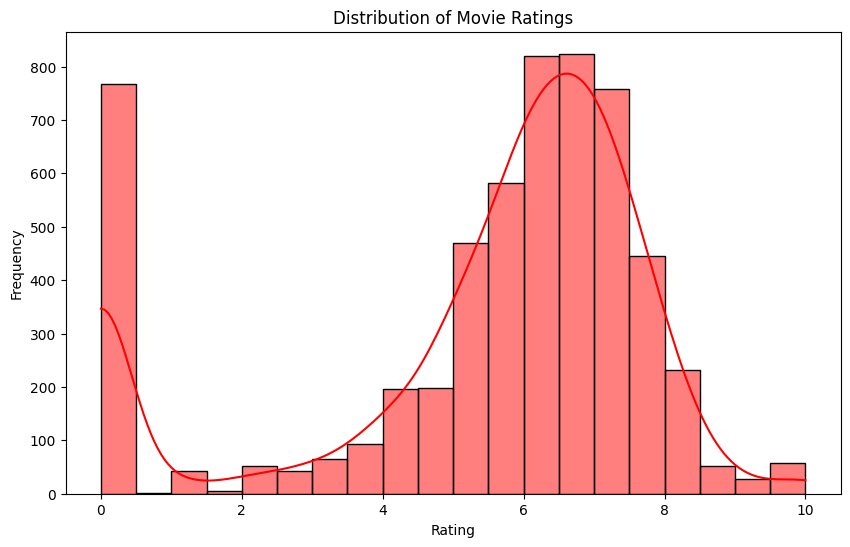

In [5]:
# Visualize the distribution of movie ratings
plt.figure(figsize=(10,6))
sns.histplot(df['rating'], bins=20,color='r', kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.savefig('rating_distribution.png')
plt.show()

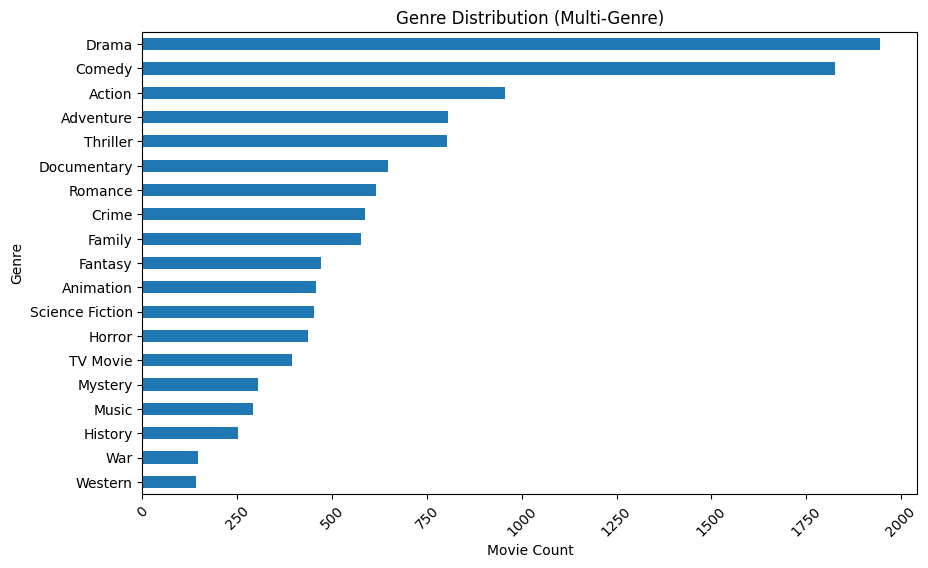

In [6]:
# Distribution of movie genres
df['genre_list'] = df['genres'].str.split(', ')
genre_exploded = df.explode('genre_list')

genre_counts = genre_exploded['genre_list'].value_counts()

plt.figure(figsize=(10, 6))
genre_counts.sort_values().plot(kind='barh')
plt.title("Genre Distribution (Multi-Genre)")
plt.xlabel("Movie Count")
plt.ylabel("Genre")
plt.xticks(rotation=45)
plt.savefig('genre_distribution.png')
plt.show()


C:\Users\bedos\AppData\Local\Temp\ipykernel_15348\1730865452.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=actor_counts.values, y=actor_counts.index, palette='viridis')


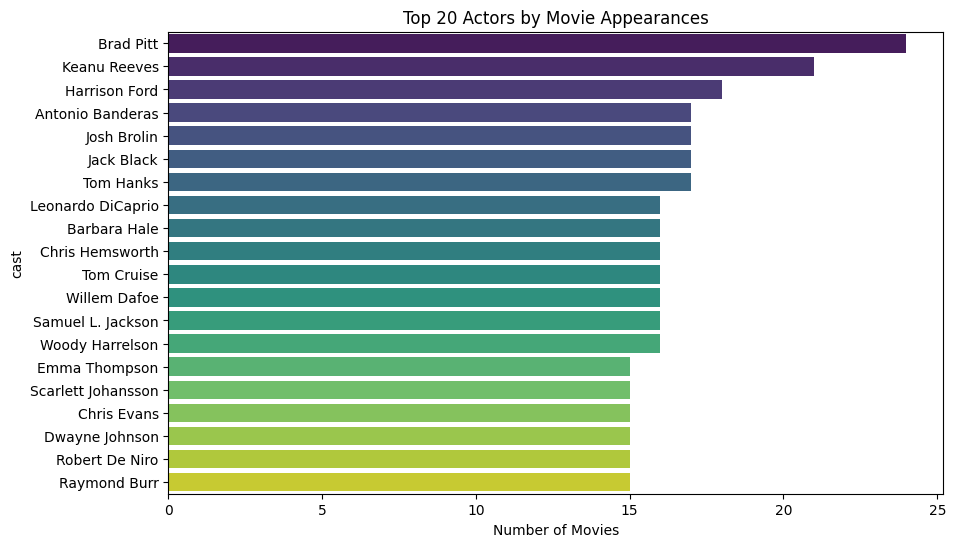

In [7]:
# Top 20 actors by movie appearances

actor = df['cast'].str.split(', ').explode()
actor_counts = actor.value_counts().head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=actor_counts.values, y=actor_counts.index, palette='viridis')
plt.title('Top 20 Actors by Movie Appearances')
plt.xlabel('Number of Movies')
plt.savefig('top_20_actors.png')
plt.show()

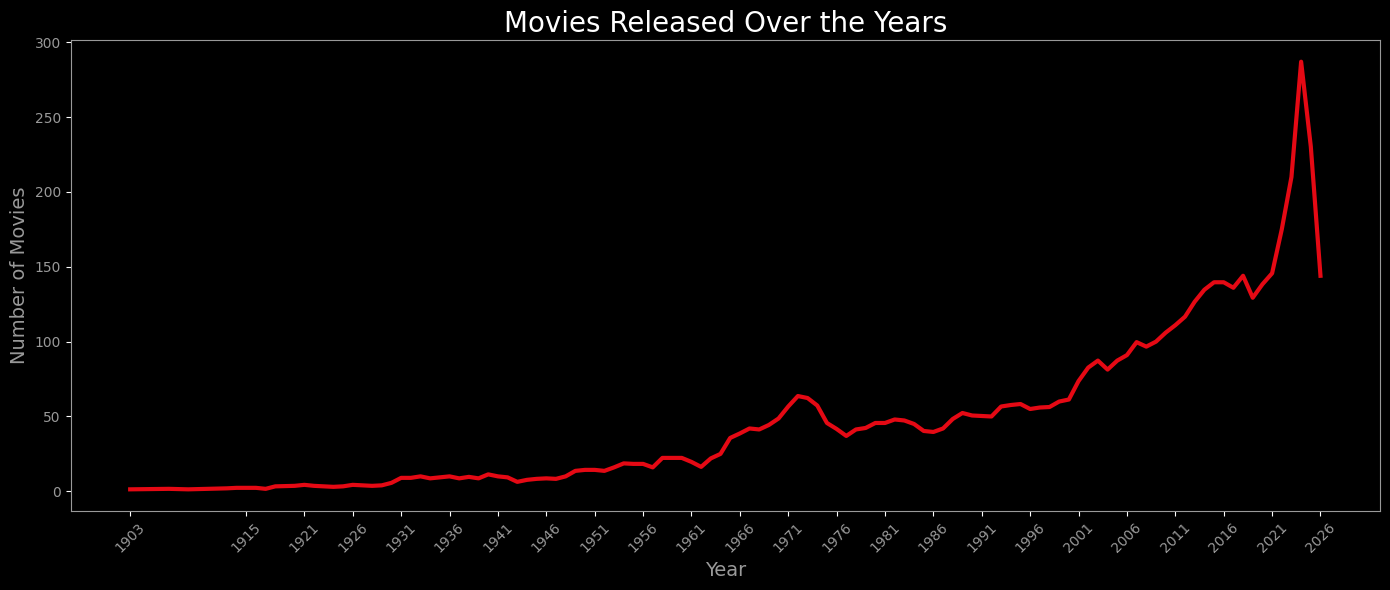

In [10]:
#Distribution of movie release years

dates = df['release_date'].value_counts().sort_index()

smooth = dates.rolling(window=3, center=True).mean().dropna()

# Netflix dark style
plt.style.use("dark_background")

NETFLIX_RED  = "#E50914"
NETFLIX_GRAY = "#999999"

plt.figure(figsize=(14,6))
ax = plt.gca()

# Background
ax.set_facecolor("black")
plt.plot(smooth.index, smooth.values, 
         color=NETFLIX_RED, linewidth=3)

# Titles and labels
plt.title("Movies Released Over the Years", fontsize=20, color="white")
plt.xlabel("Year", fontsize=14, color=NETFLIX_GRAY)
plt.ylabel("Number of Movies", fontsize=14, color=NETFLIX_GRAY)

# Ticks
plt.xticks(smooth.index[::5], rotation=45, color=NETFLIX_GRAY)
plt.yticks(color=NETFLIX_GRAY)

# Borders
for spine in ax.spines.values():
    spine.set_color(NETFLIX_GRAY)

plt.tight_layout()
plt.savefig('movie_release_year_distribution.png')
plt.show()


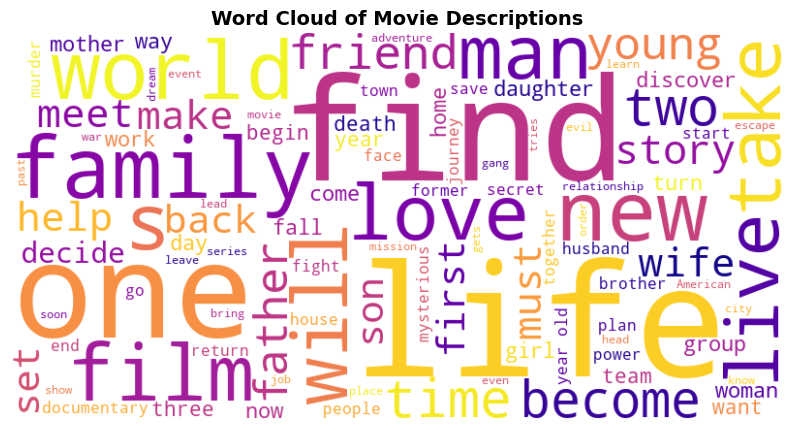

In [8]:
# Plot 3: Word Cloud for Descriptions
#The movie descriptions are visualized using a word cloud to highlight the most frequent terms.


plt.figure(figsize=(10, 6))
text = ' '.join(df['description'].dropna())
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white', colormap='plasma').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Descriptions', fontsize=14, weight='bold')
plt.savefig('movie_descriptions_wordcloud.png')
plt.show()
plt.close()

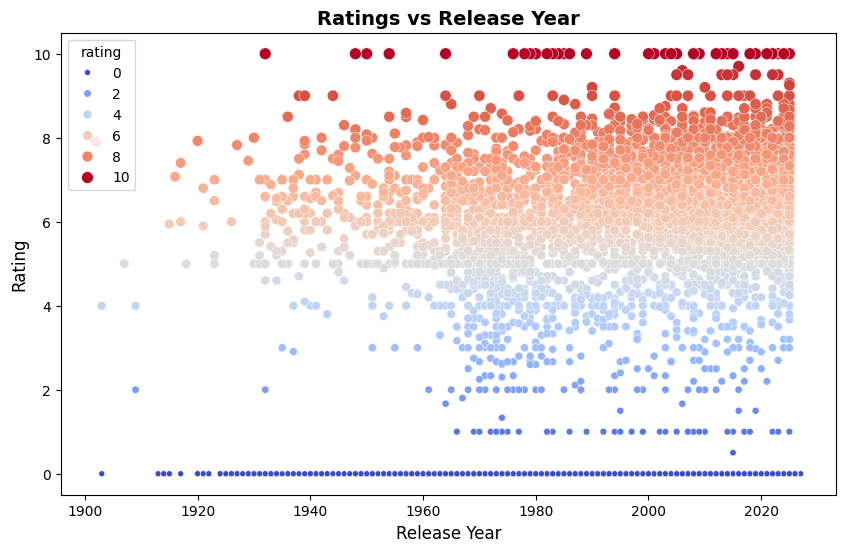

In [9]:
# Plot 4: Ratings vs Release Year

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='release_date',
    y='rating',
    data=df.dropna(subset=['release_date', 'rating']),
    hue='rating',
    palette='coolwarm',
    size='rating'
)

plt.title('Ratings vs Release Year', fontsize=14, weight='bold')
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.savefig('ratings_vs_release_year.png')
plt.show()

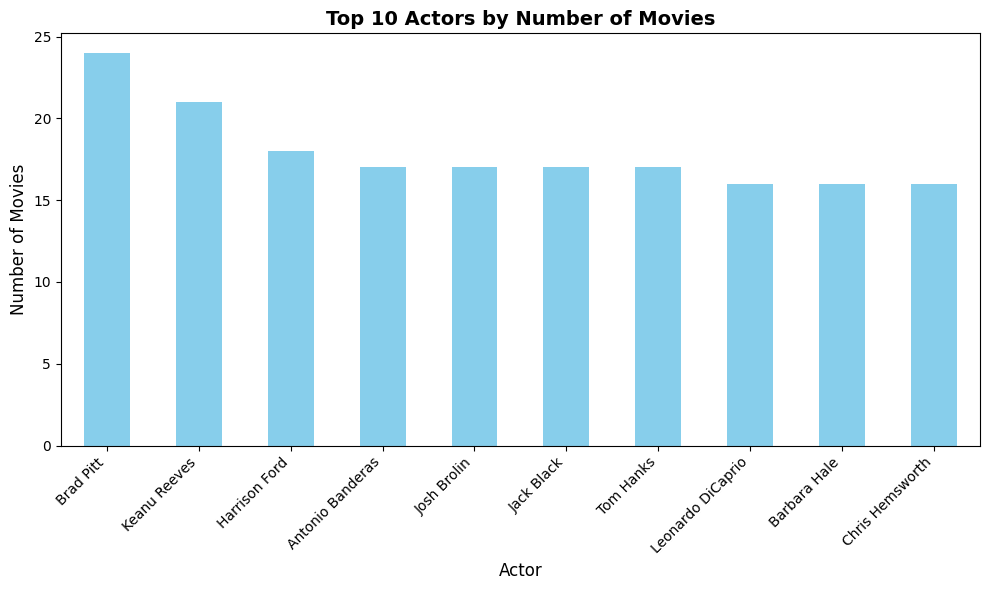

In [18]:
# Plot 6: Top Actors by Number of Movies
plt.figure(figsize=(10, 6))
actors_list = df['cast'].str.split(', ', expand=True).stack().value_counts().head(10)
actors_list.plot(kind='bar', color='skyblue')
plt.title('Top 10 Actors by Number of Movies', fontsize=14, weight='bold')
plt.xlabel('Actor', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_10_actors.png')
plt.show()
plt.close()


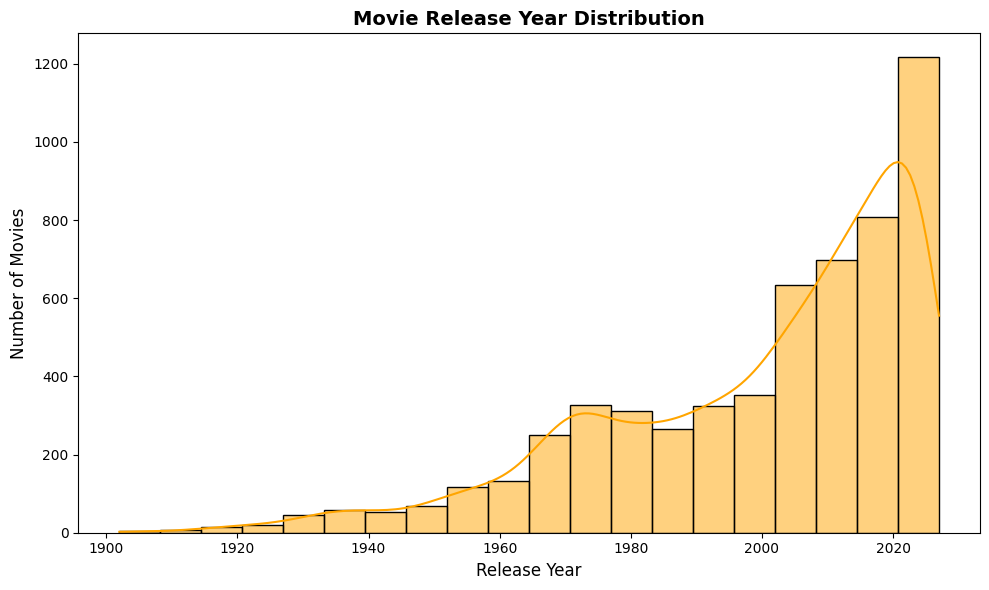

In [19]:
# Plot 8: Movie Release Year Distribution
plt.style.use('seaborn-v0_8-deep')
plt.figure(figsize=(10, 6))
sns.histplot(df['release_date'].dropna(), bins=20, kde=True, color='orange')
plt.title('Movie Release Year Distribution', fontsize=14, weight='bold')
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.tight_layout()
plt.savefig('movie_release_year_distribution.png')
plt.show()
plt.close()

C:\Users\bedos\AppData\Local\Temp\ipykernel_13208\790720171.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='genre', y='rating', data=genre_df, palette='Set2')


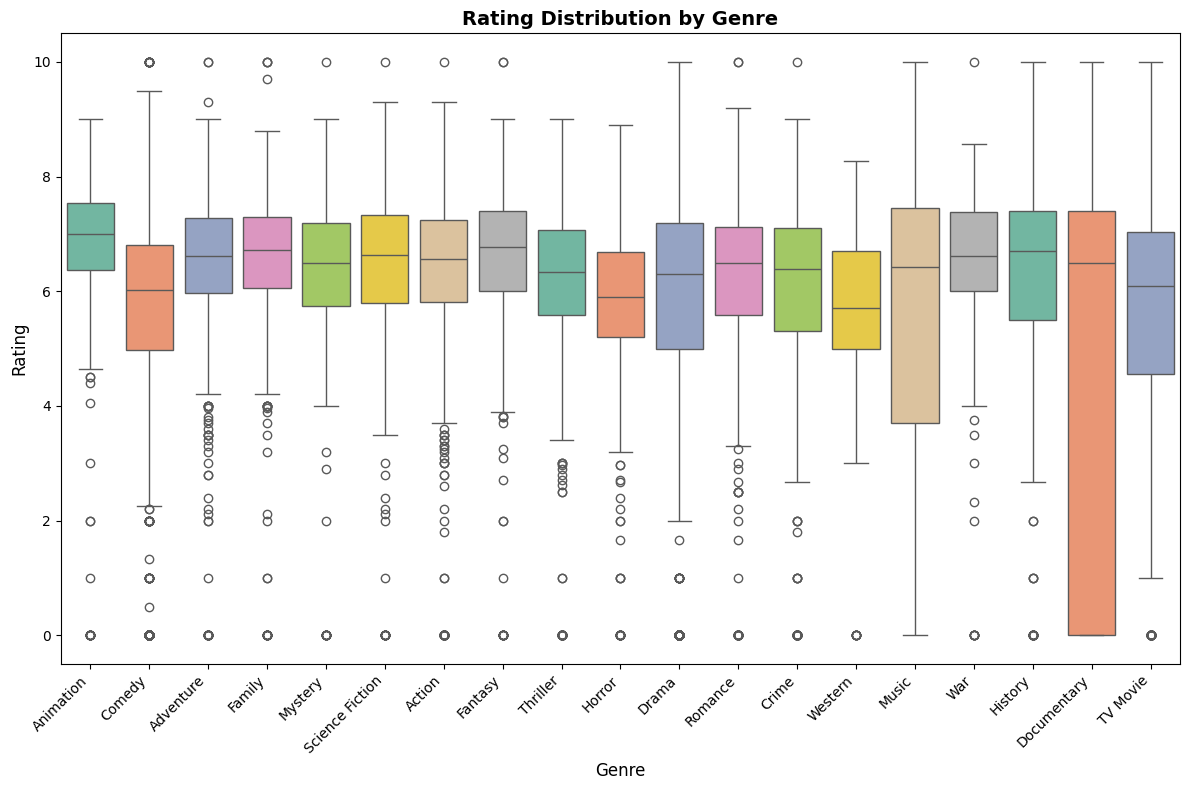

In [20]:
# Plot 9: Genre vs Rating
genre_df = (
    df
    .dropna(subset=['genres', 'rating'])
    .assign(genre=df['genres'].str.split(', '))
    .explode('genre')
)
plt.figure(figsize=(12, 8))
sns.boxplot(x='genre', y='rating', data=genre_df, palette='Set2')
plt.title('Rating Distribution by Genre', fontsize=14, weight='bold')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('genre_vs_rating.png')
plt.show()
plt.close()

**Text Representation**



**First**

remove special characters, spaces, hyphens, and underscores; convert to lowercase 
Not applied to Description, as it may contain meaningful punctuation

In [34]:
def normalize_token(token):
    if not isinstance(token, str):
        return ""
    token = token.lower()
    token = re.sub(r'[\s\-_]+', '', token)     # remove spaces, - , _
    token = re.sub(r'[^a-z0-9]', '', token)    # remove anything else
    return token


**Second**

For Genres and Cast names we remove the spaces, hyphens,etc between the one entity 
as if Van Diesel to be VanDiesel and let's say Sci-Fi to be SciFi

In [35]:
df['genres_list'] = df['genres'].apply(lambda x: str(x))
df['genres_list'] = df['genres_list'].apply(lambda x: [normalize_token(genre) for genre in x.split(', ')])
df['genres_list'] = df['genres_list'].apply(lambda lst: " ".join(x for x in lst)
                                            if isinstance(lst, list) else "")  # convert the list to one string

df['genres_list'].head()


0    animation comedy adventure family mystery
1              sciencefiction adventure action
2                      action fantasy thriller
3                              horror thriller
4      fantasy animation action sciencefiction
Name: genres_list, dtype: object

In [36]:
df['cast_list'] = df['cast'].apply(lambda x: str(x))
df['cast_list'] = df['cast_list'].apply(lambda x: [normalize_token(genre) for genre in x.split(', ')])
df['cast_list'] = df['cast_list'].apply(lambda lst: " ".join(x for x in lst)
                                            if isinstance(lst, list) else "")  # convert the list to one string

df['cast_list'].head()


0    ginnifergoodwin jasonbateman kehuyquan fortune...
1    jaredleto gretalee evanpeters gilliananderson ...
2    inemariewilmann kimsfalckjrgensen madssjgrdpet...
3    joshhutcherson piperrubio elizabethlail matthe...
4    sergeiaisman michaelbeskorovainy elenachebatur...
Name: cast_list, dtype: object

**Third**

For Cleaning the description  we didn't make much work couse every word is weighting value

**SBERT Embeddings**

We used it because we want the meaning underneath


In [38]:
def clean_description(text):
    if not isinstance(text, str):
        return ""
    
    # 1. Lowercase (standard for most models)
    text = text.lower()
    
    
    # 2. Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    
    # 3. Light cleaning (Keep letters, numbers, and basic punctuation: . , ! ?)
    
    text = re.sub(r'[^a-z0-9\s.,!?]', ' ', text)
    
    # 4. Fix whitespace (remove double spaces and newlines)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def description_embeddings(df, column="description"):
    df = df.copy()
    df["clean_description"] = df[column].apply(clean_description)

    model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = model.encode(
        df["clean_description"].tolist(),
        show_progress_bar=True
    )

    return embeddings, df


**TF-IDF Vectorixation**

In [18]:
# TF-IDF Vectorization for genres and cast

def tfidf_vectorization(df, column):
    df = df.copy()
    vectorizer = TfidfVectorizer(
        max_features=5000,
        stop_words='english'
    )
    tfidf_matrix = vectorizer.fit_transform(df[column].fillna(""))

    return tfidf_matrix, df

In [39]:
desc_emb, movies_df = description_embeddings(df)
genre_tfidf, movies_df = tfidf_vectorization(movies_df, 'genres_list')
cast_tfidf, movies_df = tfidf_vectorization(movies_df, 'cast_list')

Batches:   0%|          | 0/164 [00:00<?, ?it/s]

**Similarity**

We work with weights to make the sim in Description value more than in sim in Genres or Cast 

In [40]:
def combined_similarity(
    desc_emb,
    genre_tfidf,
    cast_tfidf,
    w_desc=0.7,
    w_genre=0.2,
    w_cast=0.1
):
    sim_desc = cosine_similarity(desc_emb)
    sim_genre = cosine_similarity(genre_tfidf)
    sim_cast = cosine_similarity(cast_tfidf)

    final_sim = (
        w_desc * sim_desc +
        w_genre * sim_genre +
        w_cast * sim_cast
    )

    return final_sim

sim_matrix = combined_similarity(
    desc_emb,
    genre_tfidf,
    cast_tfidf
)

**The Final and Main Function** 

**Recommender**

Very simple way you enter the movie name , the model do it's search and see which similar to yours

In [57]:
def recommend_movies(title, df, similarity_matrix, top_n=10):
    idx = df[df["title"] == title].index[0]
    scores = list(enumerate(similarity_matrix[idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    movie_indices = [i[0] for i in scores]
    return df.iloc[movie_indices][["title"]]
recommendations = recommend_movies("Batman", movies_df, sim_matrix, top_n=5)
print("Recommendations for 'Batman':")
print(recommendations)

Recommendations for 'Batman':
                                  title
433                       Batman Begins
115                     The Dark Knight
450  Batman v Superman: Dawn of Justice
402               The Dark Knight Rises
334                          The Batman


Another Example 

In [26]:
recs = recommend_movies("Extraction", movies_df, sim_matrix, top_n=5)
print("Recommendations for 'Extraction':")
print(recs)

Recommendations for 'Extraction':
             title
2959  Extraction 2
5546  The Gray Man
3286   Man on Fire
2328   The Painter
660    Raw Justice


In [18]:
df.sample(5)

,title,rating,genres,description,release_date,poster,cast,genres_list,cast_list
3531,The Dark and the Wicked,6.185,Horror,On a secluded farm in a nondescript rural town...,2020.0,https://image.tmdb.org/t/p/w500/4DB9VFVTp0IQEW...,"Marin Ireland, Michael Abbott Jr., Xander Berk...",horror,marinireland michaelabbottjr xanderberkeley ly...
3854,Maze Runner: The Death Cure,7.100,"Science Fiction, Action, Adventure, Thriller",Thomas leads his group of escaped Gladers on t...,2018.0,https://image.tmdb.org/t/p/w500/drbERzlA4cuRWh...,"Dylan O'Brien, Kaya Scodelario, Thomas Brodie-...",sciencefiction action adventure thriller,dylanobrien kayascodelario thomasbrodiesangste...
1185,"My Darling, What Have You Done to Me?",3.714,"Comedy, Crime, Drama",What seemed like a naive adventure of love bec...,1979.0,https://image.tmdb.org/t/p/w500/8hKeL2tKXV1lOc...,"Vicente Parra, Raquel Evans, Lynn Endersson, M...",comedy crime drama,vicenteparra raquelevans lynnendersson maralas...
1760,The Muppets,6.683,"Family, Comedy, Music",When Kermit the Frog and the Muppets learn tha...,2011.0,https://image.tmdb.org/t/p/w500/mOB0Hdm23NslPN...,"Jason Segel, Amy Adams, Chris Cooper, Rashida ...",family comedy music,jasonsegel amyadams chriscooper rashidajones s...
3242,Challenge of McKenna,4.700,Western,A former priest becomes embroiled in the drama...,1970.0,https://image.tmdb.org/t/p/w500/fsp3xaijhU4BoY...,"Robert Woods, John Ireland, Annabella Incontre...",western,robertwoods johnireland annabellaincontrera da...


**Accuracy**

In [21]:

def precision_at_k(query_idx, rec_indices, df, k=10):
    query_genres = set(df.iloc[query_idx]["genres"])
    hits = 0

    for idx in rec_indices[:k]:
        rec_genres = set(df.iloc[idx]["genres"])
        if query_genres & rec_genres:
            hits += 1

    return hits / k
def evaluate_recommendations(df, similarity_matrix, k=10):
    precisions = []

    for idx in range(len(df)):
        scores = list(enumerate(similarity_matrix[idx]))
        scores = sorted(scores, key=lambda x: x[1], reverse=True)[1:k+1]
        rec_indices = [i[0] for i in scores]

        p_at_k = precision_at_k(idx, rec_indices, df, k)
        precisions.append(p_at_k)

    avg_precision = np.mean(precisions)
    print(f"Average Precision@{k}: {avg_precision:.4f}")
    return avg_precision
evaluate_recommendations(movies_df, sim_matrix, k=10)


Average Precision@10: 1.0000


np.float64(1.0)

In [1]:
import pickle

data = pickle.load(open('data.pkl', 'rb'))

data.columns

Index(['title', 'rating', 'genres', 'description', 'release_date', 'poster',
       'cast', 'genre_list', 'genres_list', 'cast_list'],
      dtype='object')

In [72]:
class Recommender:
    def __init__(self, df):
        self.df = df.copy()
        self.desc_embeddings = None
        self.genre_tfidf = None
        self.cast_tfidf = None
        self.similarity_matrix = None
        self.processed_df = None
        
    def normalize_token(self, token):
        if not isinstance(token, str):
            return ""
        token = token.lower()
        token = re.sub(r'[\s\-_]+', '', token)     # remove spaces, - , _
        token = re.sub(r'[^a-z0-9]', '', token)    # remove anything else
        return token
    
    def process_genres(self):
        self.df['genres_list'] = self.df['genres'].apply(lambda x: str(x))
        self.df['genres_list'] = self.df['genres_list'].apply(lambda x: [self.normalize_token(genre) for genre in x.split(', ')])
        self.df['genres_list'] = self.df['genres_list'].apply(lambda lst: " ".join(x for x in lst)
                                            if isinstance(lst, list) else "")  # convert the list to one string
        return self.df['genres_list']

    def process_cast(self):
        self.df['cast_list'] = self.df['cast'].apply(lambda x: str(x))
        self.df['cast_list'] = self.df['cast_list'].apply(lambda x: [self.normalize_token(actor) for actor in x.split(', ')])
        self.df['cast_list'] = self.df['cast_list'].apply(lambda lst: " ".join(x for x in lst)
                                            if isinstance(lst, list) else "")  # convert the list to one string

        return self.df['cast_list']
    
    def clean_description(self, text):
        if not isinstance(text, str):
            return ""
        text = text.lower()
        text = re.sub(r'<.*?>', ' ', text)
        text = re.sub(r'[^a-z0-9\s.,!?]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    


    
    def generate_description_embeddings(self, column="description"):
        self.df["clean_description"] = self.df[column].apply(self.clean_description)
        
        model = SentenceTransformer("all-MiniLM-L6-v2")
        embeddings = model.encode(
            self.df["clean_description"].tolist(),
            show_progress_bar=True
        )
        
        return embeddings, self.df
    
    def tfidf_vectorization(self, column):
        self.df = self.df.copy()
        vectorizer = TfidfVectorizer(
            max_features=5000,
            stop_words='english'
        )
        tfidf_matrix = vectorizer.fit_transform(self.df[column].fillna(""))
        
        return tfidf_matrix, self.df
    
    def combined_similarity(
        self,
        desc_emb,
        genre_tfidf,
        cast_tfidf,
        w_desc=0.7,
        w_genre=0.2,
        w_cast=0.1
    ):
        sim_desc = cosine_similarity(desc_emb)
        sim_genre = cosine_similarity(genre_tfidf)
        sim_cast = cosine_similarity(cast_tfidf)
        
        final_sim = (
            w_desc * sim_desc +
            w_genre * sim_genre +
            w_cast * sim_cast
        )
        
        return final_sim
    
    def fit(self, w_desc=0.7, w_genre=0.2, w_cast=0.1):
        # Process genres and cast
        self.process_genres()
        self.process_cast()
        
        # Generate description embeddings
        self.desc_embeddings, self.processed_df = self.generate_description_embeddings()
        
        # Generate TF-IDF matrices
        self.genre_tfidf, _ = self.tfidf_vectorization('genres_list')
        self.cast_tfidf, _ = self.tfidf_vectorization('cast_list')
        
        # Calculate combined similarity matrix
        self.similarity_matrix = self.combined_similarity(
            self.desc_embeddings,
            self.genre_tfidf,
            self.cast_tfidf,
            w_desc, w_genre, w_cast
        )
        
        return self
    
    def recommend(self, movie_title, num_recommendations=5):
        if self.similarity_matrix is None:
            raise ValueError("Model not fitted yet. Call fit() method first.")
        
        # Find the index of the movie
        try:
            movie_idx = self.processed_df[self.processed_df['title'].str.lower() == movie_title.lower()].index[0]
        except IndexError:
            # If exact match not found, try partial match
            movie_indices = self.processed_df[self.processed_df['title'].str.lower().str.contains(movie_title.lower())].index
            if len(movie_indices) == 0:
                raise ValueError(f"Movie '{movie_title}' not found in the dataset.")
            movie_idx = movie_indices[0]  # Take the first match
        
        # Get similarity scores for the movie
        sim_scores = list(enumerate(self.similarity_matrix[movie_idx]))
        
        # Sort movies based on similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # Get the indices of most similar movies
        movie_indices = [i[0] for i in sim_scores[1:num_recommendations+1]]  # Exclude the movie itself
        
        # Return the recommended movies
        recommendations = self.processed_df.iloc[movie_indices][['title', 'genres', 'cast', 'description','poster']].copy()
        recommendations['similarity_score'] = [sim_scores[i+1][1] for i in range(len(movie_indices))]
        
        return recommendations
    
    def evaluate(self, test_movies=None, num_recommendations=5):
        """
        Evaluate the recommender system by calculating precision and recall
        """
        if test_movies is None:
            # Use a random sample of movies for evaluation
            test_movies = self.processed_df.sample(min(10, len(self.processed_df)))['title'].tolist()
        
        total_precision = 0
        total_recall = 0
        total_f1 = 0
        valid_evaluations = 0
        
        for movie in test_movies:
            try:
                recommendations = self.recommend(movie, num_recommendations)
                
                # For evaluation, we can calculate how diverse the recommendations are
                # or how well they match the original movie's genre/cast
                original_movie = self.processed_df[self.processed_df['title'].str.lower() == movie.lower()]
                if original_movie.empty:
                    continue
                
                original_genres = set(original_movie.iloc[0]['genres'].lower().split(', '))
                original_cast = set(original_movie.iloc[0]['cast'].lower().split(', '))
                
                # Calculate how many recommended movies share genres or cast with original
                relevant_recommendations = 0
                for _, rec in recommendations.iterrows():
                    rec_genres = set(rec['genres'].lower().split(', '))
                    rec_cast = set(rec['cast'].lower().split(', '))
                    
                    # Check if there's overlap in genres or cast
                    if original_genres.intersection(rec_genres) or original_cast.intersection(rec_cast):
                        relevant_recommendations += 1
                
                # Calculate metrics
                precision = relevant_recommendations / num_recommendations if num_recommendations > 0 else 0
                recall = relevant_recommendations / min(num_recommendations, len(self.processed_df)-1) if len(self.processed_df) > 1 else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                
                total_precision += precision
                total_recall += recall
                total_f1 += f1
                valid_evaluations += 1
                
            except Exception as e:
                print(f"Error evaluating movie '{movie}': {e}")
                continue
        
        if valid_evaluations > 0:
            avg_precision = total_precision / valid_evaluations
            avg_recall = total_recall / valid_evaluations
            avg_f1 = total_f1 / valid_evaluations
            
            evaluation_results = {
                'avg_precision': avg_precision,
                'avg_recall': avg_recall,
                'avg_f1_score': avg_f1,
                'num_evaluated': valid_evaluations,
                'total_test_movies': len(test_movies)
            }
            
            return evaluation_results
        

# Example usage:
recommender = Recommender(movies_df)
recommender.fit(w_desc=0.7, w_genre=0.2, w_cast=0.1)
recommendations = recommender.recommend("Inception")
evaluation = recommender.evaluate()

Batches:   0%|          | 0/164 [00:00<?, ?it/s]

In [73]:
print("Recommendations for 'Inception':")
print(recommendations)
print("Evaluation Results:")
print(evaluation)

Recommendations for 'Inception':
                         title                              genres  \
3129               The Creator  Science Fiction, Action, Adventure   
625                       Tron  Science Fiction, Action, Adventure   
362               TRON: Legacy  Adventure, Action, Science Fiction   
10          Predator: Badlands  Action, Science Fiction, Adventure   
906   The Matrix Resurrections  Science Fiction, Action, Adventure   

                                                   cast  \
3129  John David Washington, Madeleine Yuna Voyles, ...   
625   Jeff Bridges, Bruce Boxleitner, David Warner, ...   
362   Garrett Hedlund, Olivia Wilde, Jeff Bridges, B...   
10    Elle Fanning, Dimitrius Schuster-Koloamatangi,...   
906   Keanu Reeves, Carrie-Anne Moss, Yahya Abdul-Ma...   

                                            description  \
3129  Amid a future war between the human race and t...   
625   When brilliant video game maker Flynn hacks th...   
362   Sam Flyn

In [74]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(recommender, f)

with open('data.pkl', 'wb') as f:
    pickle.dump(movies_df,f)

    